<a href="https://colab.research.google.com/github/davidsjohnson/blockies-xai/blob/xai-david/CRP_explanation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!rm -rf blockies-xai
!git clone https://github.com/davidsjohnson/blockies-xai
%cd blockies-xai
!git fetch
!git checkout XAI
%cd ..

Cloning into 'blockies-xai'...
remote: Enumerating objects: 85, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 85 (delta 6), reused 11 (delta 3), pack-reused 70 (from 1)
Receiving objects: 100% (85/85), 139.42 MiB | 21.42 MiB/s, done.
Resolving deltas: 100% (29/29), done.
/content/blockies-xai
Branch 'XAI' set up to track remote branch 'XAI' from 'origin'.
Switched to a new branch 'XAI'
/content


In [ ]:
%pip install -q torchinfo

In [ ]:
import pathlib
import os
import sys
from pathlib import Path
import tarfile
import random

# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchvision.transforms as T
from tqdm import tqdm

from PIL import Image

torch.backends.cudnn.benchmark = True

# Params

In [ ]:
CLASSES = ['Healthy', 'OC Degeneration']

load_checkpoints = True

modeltype = 'mobilenet'

ds = 'sick_ones_bendbias_v3_2class_normal'
eval_ds = 'sick_ones_bendbias_v3_2class_variation'

# Setup and Load Datasets

In [ ]:
relative_model_path = "two4two_sickones_models_pytorch"
base_path = Path('./') / relative_model_path
base_path

PosixPath('two4two_sickones_models_pytorch')

In [ ]:
def load_dataframe(data_dir, dataset):
  data_dir = data_dir / dataset
  df = pd.read_json(data_dir / 'parameters.jsonl', lines=True)
  df['filename'] = df['id'] + '.png'
  df['ill'] = df['ill'].astype(int).astype(str)

  return df

class ImageDataset(Dataset):
    def __init__(self, df, data_dir, transform=None):
        self.df = df
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(str(self.data_dir), str(row['filename'])) ## Added str
        image = Image.open(img_path).convert('RGB')
        label = int(row['ill'])
        ill_chars = ",".join(map(str, row['ill_chars']))

        if self.transform:
            image = self.transform(image)

        return image, label, ill_chars

class DatasetWrapper(Dataset):
  def __init__(self, dataset) -> None:
     super().__init__()

     self.dataset = dataset

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, index):
    data = self.dataset[index]

    return data[0], data[1]

## Load Dataset and Dataloaders


In [ ]:

def download_file(url, file_name, cache_dir="data", extract=True, force_download=False, archive_folder=None):
    # Ensure the cache directory exists
    os.makedirs(cache_dir, exist_ok=True)
    file_path = os.path.join(cache_dir, file_name)

    # Download the file
    if not os.path.exists(file_path) or force_download:
      torch.hub.download_url_to_file(url, file_path)
      print(f"File downloaded to: {file_path}")
    else:
      print(f"File already exists at: {file_path}")

    if extract:
      with tarfile.open(file_path, "r:gz") as tar:
          tar.extractall(path=cache_dir)
      print(f"File extracted to: {cache_dir}")
      return Path(cache_dir) / archive_folder if archive_folder is not None else Path(cache_dir)
    elif archive_folder is not None and (Path(cache_dir) / archive_folder).exists():
      return Path(cache_dir) / archive_folder if archive_folder is not None else Path(cache_dir)
    else:
      return Path(cache_dir)

    return Path(file_path)

In [ ]:
data_dir = download_file(url="https://osf.io/download/kexzt/?view_only=adcc520b88cc4ea3b8236c5178ba3ab5",
                         file_name="blockies_datasets.tar.gz",
                         cache_dir='/content/data', # change this if not using Colab
                         extract=True,
                         force_download=False,
                         archive_folder='blockies_datasets')


ds_dir = data_dir / ds
eval_ds_dir = data_dir / eval_ds
ds_dir, eval_ds_dir

File already exists at: /content/data/blockies_datasets.tar.gz
File extracted to: /content/data


(PosixPath('/content/data/blockies_datasets/sick_ones_bendbias_v3_2class_normal'),
 PosixPath('/content/data/blockies_datasets/sick_ones_bendbias_v3_2class_variation'))

In [ ]:
train_df = load_dataframe(ds_dir, 'train')
train_transforms = T.Compose([
    T.ToTensor()
])
train_dataset = ImageDataset(train_df, ds_dir / 'train', transform=train_transforms)
dataloader = DataLoader(train_dataset, batch_size=100, shuffle=True,
                        num_workers=6, pin_memory=True)

# Initialize variables to calculate mean
mean = torch.zeros(3)  # For RGB channels
total_pixels = 0

# Loop through the dataset
for images, _, _ in tqdm(dataloader):
    # Sum pixel values per channel
    mean += images.sum(dim=[0, 2, 3])
    total_pixels += images.size(0) * images.size(2) * images.size(3)

# Divide by total number of pixels
mean /= total_pixels

print(f"Mean per channel: {mean}")

# Initialize variables for std calculation
std = torch.zeros(3)

# Loop again for standard deviation
for images, _, _ in tqdm(dataloader):
    std += ((images - mean.view(1, 3, 1, 1))**2).sum(dim=[0, 2, 3])

std = torch.sqrt(std / total_pixels)

print(f"Standard Deviation per channel: {std}")

100%|██████████| 400/400 [00:11<00:00, 35.24it/s]


Mean per channel: tensor([0.8068, 0.7830, 0.8005])


100%|██████████| 400/400 [00:11<00:00, 34.91it/s]

Standard Deviation per channel: tensor([0.1093, 0.1136, 0.1029])


In [ ]:
train_df = load_dataframe(ds_dir, 'train')
val_df = load_dataframe(ds_dir, 'validation')
test_df = load_dataframe(ds_dir, 'test')
eval_df = load_dataframe(eval_ds_dir, 'test')

In [ ]:
len(val_df), len(test_df), len(eval_df), len(train_df)

(1000, 3000, 3000, 40000)

In [ ]:
transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=mean, std=std)
])

In [ ]:
test_df['filename'] = test_df['filename'].astype(str).str.strip()
for i, fname in enumerate(test_df['filename']):
    if '\n' in fname or ' ' in fname:
        print(f"[WARNING] Bad filename in row {i}: {repr(fname)}")

In [ ]:
train_dataset = ImageDataset(train_df, ds_dir / 'train', transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True,
                              num_workers=6, pin_memory=True)

train_eval_dataset = ImageDataset(train_df, ds_dir / 'train', transform=transform)
train_eval_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False,
                                   num_workers=6, pin_memory=True)

val_dataset = ImageDataset(val_df,  ds_dir / 'validation', transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False,
                            num_workers=6, pin_memory=True)

test_dataset = ImageDataset(test_df,  ds_dir / 'test', transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False,
                             num_workers=6, pin_memory=True)

eval_dataset = ImageDataset(eval_df,  eval_ds_dir / 'test', transform=transform)
eval_dataloader = DataLoader(eval_dataset, batch_size=32, shuffle=False,
                             num_workers=6, pin_memory=True)

In [ ]:
data_ex = next(iter(train_dataloader))
data_ex[0].shape, data_ex[1].shape, len(data_ex[2])

(torch.Size([32, 3, 128, 128]), torch.Size([32]), 32)

## Analysis Dataset

In [ ]:
# create column for absolute sphere difference
train_df['sphere_diff'] = np.abs(train_df['spherical'] - train_df['ill_spherical'])
val_df['sphere_diff'] = np.abs(val_df['spherical'] - val_df['ill_spherical'])
test_df['sphere_diff'] = np.abs(test_df['spherical'] - test_df['ill_spherical'])
eval_df['sphere_diff'] = np.abs(eval_df['spherical'] - eval_df['ill_spherical'])

# Model Training and Evaluation

In [ ]:
from torchinfo import summary

In [ ]:
def set_seed(seed):
  """
  Sets random seeds for reproducibility.
  """
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False


def evaluate_model(model, dataloader, criterion, device):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0

    preds = []
    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels, _ in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Track loss and accuracy
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            preds.extend(predicted.cpu().numpy())
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_loss = running_loss / len(dataloader)
    accuracy = correct / total

    print(f"Evaluation Loss: {avg_loss:.4f}, Evaluation Accuracy: {accuracy:.4f}")
    return avg_loss, accuracy, np.array(preds)

In [ ]:
def load_resnet50(num_classes, pretrained=True, checkpoint_path=None):
    """Loads a ResNet-50 model, optionally loading from a checkpoint.

    Args:
      num_classes: Number of output classes.
      pretrained: Whether to load pretrained weights.
      checkpoint_path: Path to a checkpoint file to load.

    Returns:
      A ResNet-50 model.
    """
    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT if pretrained else None)
    model.fc = nn.Linear(model.fc.in_features, num_classes)  # Replace final fully-connected layer

    if checkpoint_path:
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint)
        print(f"Loaded checkpoint from: {checkpoint_path}")

    return model


In [ ]:
# setup checkpoint folders
checkpoint_path = Path("/content/blockies-xai/two4two_sickones_models_pytorch/sick_ones_bendbias_v3_2class_normal/mobilenet/torch_resnet50")
(checkpoint_path / 'tmp').mkdir(parents=True, exist_ok=True)
(checkpoint_path / 'final').mkdir(parents=True, exist_ok=True)

In [ ]:
# Define loss function
criterion = nn.CrossEntropyLoss()
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
# load best model and evaluate

model = load_resnet50(num_classes=len(CLASSES),
                         pretrained=False,
                         checkpoint_path=checkpoint_path / 'final' / 'best_model.pth')
model.to(device);


Loaded checkpoint from: /content/blockies-xai/two4two_sickones_models_pytorch/sick_ones_bendbias_v3_2class_normal/mobilenet/torch_resnet50/final/best_model.pth


In [ ]:
# _ = evaluate_model(model, train_dataloader, criterion, device)
_ = evaluate_model(model, val_dataloader, criterion, device)
_ = evaluate_model(model, test_dataloader, criterion, device)
_ = evaluate_model(model, eval_dataloader, criterion, device)

Evaluation Loss: 0.2712, Evaluation Accuracy: 0.8820
Evaluation Loss: 0.3002, Evaluation Accuracy: 0.8677
Evaluation Loss: 1.0341, Evaluation Accuracy: 0.6570


In [ ]:
# summary(model, input_size=(1, 3, 224, 224))
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
summary(model, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 2]                    --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 256, 56, 56]          --
│    └─Bottleneck: 2-1                   [1, 256, 56, 56]          --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           4,096
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│ 

# CRP Explaination

In [ ]:
%pip install -q zennit-crp[fast_img]

In [ ]:
import torch
from torchvision.models.vgg import vgg16_bn
import torchvision.transforms as T
from PIL import Image

import torchvision
from crp.visualization import FeatureVisualization

from crp.attribution import CondAttribution
from crp.concepts import ChannelConcept
from crp.helper import get_layer_names

from zennit.canonizers import SequentialMergeBatchNorm
from zennit.composites import EpsilonPlusFlat
from zennit.torchvision import VGGCanonizer, ResNetCanonizer

%matplotlib inline
from crp.image import plot_grid, imgify

In [ ]:
# get sample, label and prediction

sample_idx = 5

data, labels, ill_chars = next(iter(test_dataloader))
sample = data[sample_idx]
label = labels[sample_idx]
chars = ill_chars[sample_idx]
data = sample.unsqueeze(0)
label = label.unsqueeze(0).item()
sample = data.to(device)
sample.requires_grad = True

logit = model(sample)
pred = torch.argmax(logit).item()
sample.shape, label, pred, logit, chars

(torch.Size([1, 3, 128, 128]),
 1,
 1,
 tensor([[-3.6221,  3.6200]], device='cuda:0', grad_fn=<AddmmBackward0>),
 'high_bend,mutation_mainbones,high_sphere_diff,mutation_color')

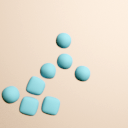

In [ ]:
imgify(sample[0])

In [ ]:
# CRP setup
cc = ChannelConcept()
composite = EpsilonPlusFlat([ResNetCanonizer()])
attribution = CondAttribution(model)

## Sample Base Heatmaps

In [ ]:
# general heatmap
conditions = [{"y": pred}]

attr = attribution(sample, conditions, composite, mask_map=cc.mask)

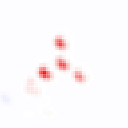

In [ ]:
imgify(attr.heatmap, symmetric=True)

In [ ]:
layer_names = get_layer_names(model, [torch.nn.Conv2d, torch.nn.Linear])
layer_map = {layer : cc for layer in layer_names}
layer_name = layer_names[-2]
layer_name

'layer4.2.conv3'

### View Top Relevance

In [ ]:
conditions = [{"y": pred}]

attr = attribution(sample, conditions, composite, mask_map=cc.mask, record_layer=layer_names)

In [ ]:
rel_c = cc.attribute(attr.relevances[layer_name], abs_norm=True)
rel_c.shape

torch.Size([1, 2048])

In [ ]:
rel_values, concept_ids = torch.topk(rel_c[0], 2048)
concept_ids[:10], rel_values[:10]*100

(tensor([1373,  103,  427,  441, 1404,  646,   16,  729, 1612, 1511],
        device='cuda:0'),
 tensor([9.6058, 8.1161, 7.9286, 6.6251, 6.3852, 6.1967, 5.3797, 4.3957, 4.3597,
         3.9236], device='cuda:0'))

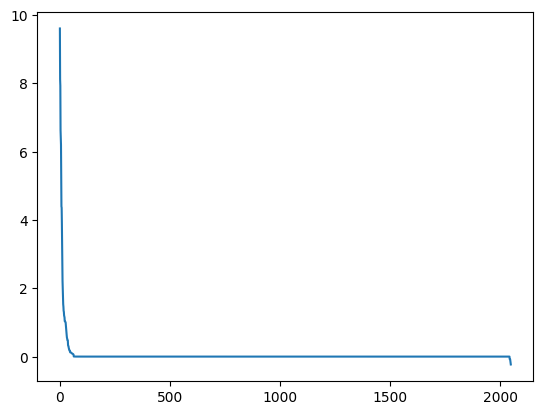

In [ ]:
plt.plot(rel_values.detach().cpu()*100)

In [ ]:
total_relevance = torch.sum(rel_values)
cumulative_relevance = torch.cumsum(rel_values, dim=0)

# Find the index where the cumulative sum reaches 95% of the total
threshold = 0.95 * total_relevance
index= torch.searchsorted(cumulative_relevance, threshold)

# The number of concepts representing % of relevance
num_concepts= index.item() + 1  # Add 1 because searchsorted returns the index *before* the threshold

print(f"The top {num_concepts} concepts represent approximately {(cumulative_relevance[index] / total_relevance * 100).item():.2f}% of the total relevance.")

The top 34 concepts represent approximately 95.40% of the total relevance.


In [ ]:
conditions = [{'y': pred, layer_name: c} for c in concept_ids[:25]]

# zennit requires gradients
sample.requires_grad = True
concept_heatmaps, _, _, _= attribution(sample, conditions, composite)

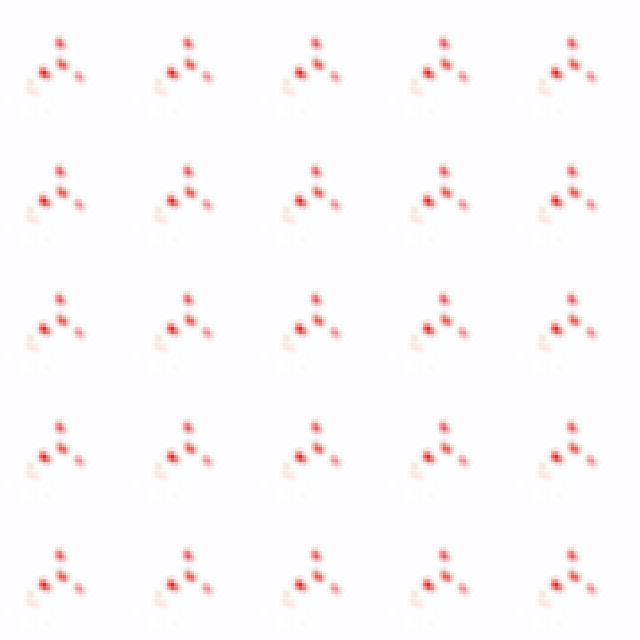

In [ ]:
imgify(concept_heatmaps, symmetric=True, grid=(5, len(concept_heatmaps) // 5))

### RelMax

In [ ]:
test_dataset_w = DatasetWrapper(test_dataset)

fv = FeatureVisualization(attribution, test_dataset_w, layer_map)
_ = fv.run(composite, 0, len(test_dataset_w), batch_size=32)

Running Analysis...


100%|██████████| 94/94 [00:40<00:00,  2.29it/s]


100%|██████████| 108/108 [00:00<00:00, 789.58it/s]


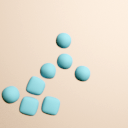

In [ ]:
imgify(sample[0])

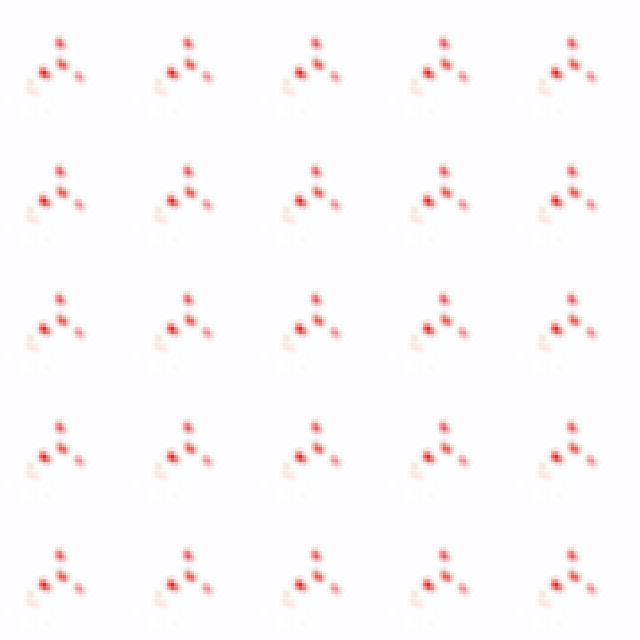

In [ ]:
imgify(concept_heatmaps, symmetric=True, grid=(5, len(concept_heatmaps) // 5))

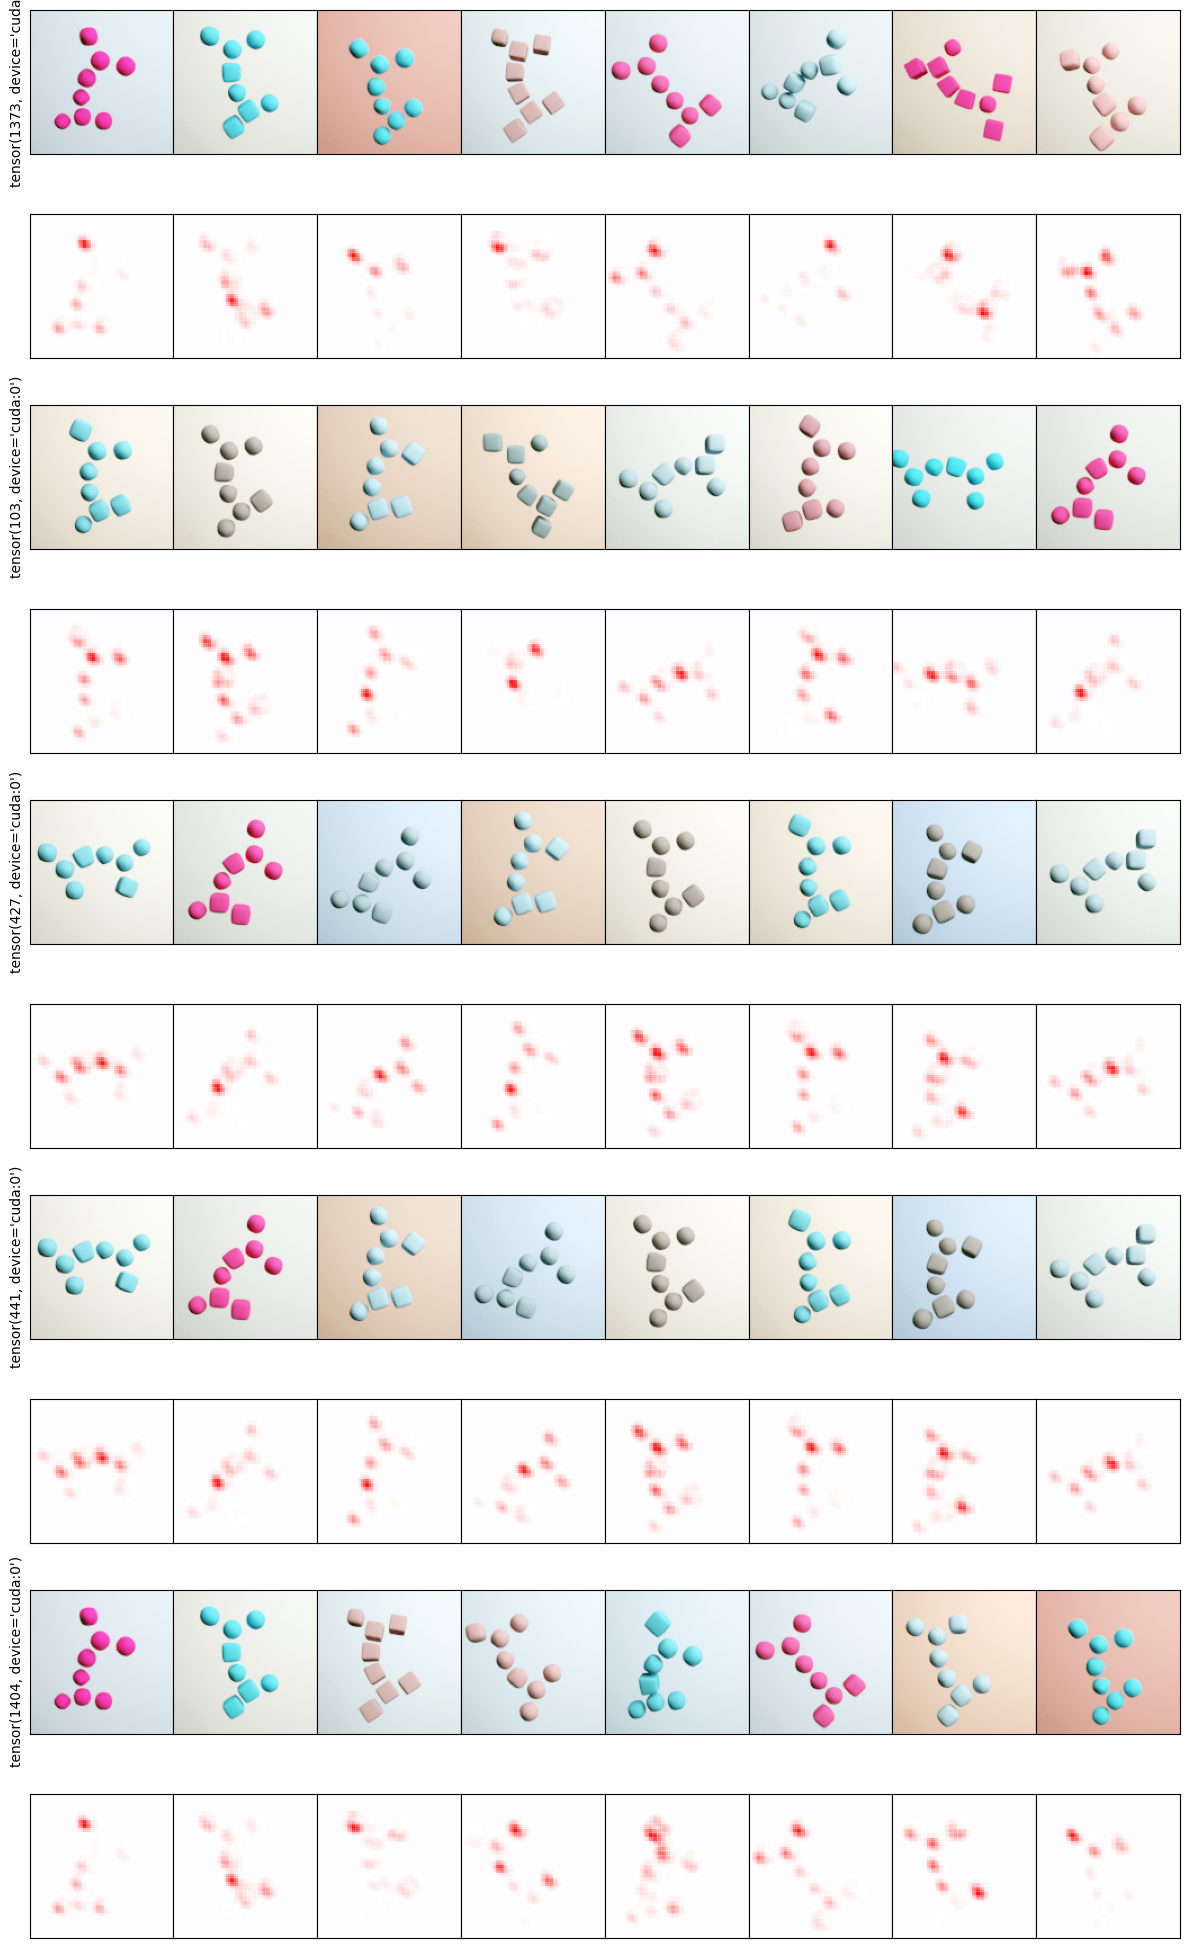

In [ ]:
# visualize MaxRelevance reference images for top concepts
ref_c = fv.get_max_reference(concept_ids[:5], layer_name, 'relevance', composite=composite)
plot_grid(ref_c, figsize=(12, 20))

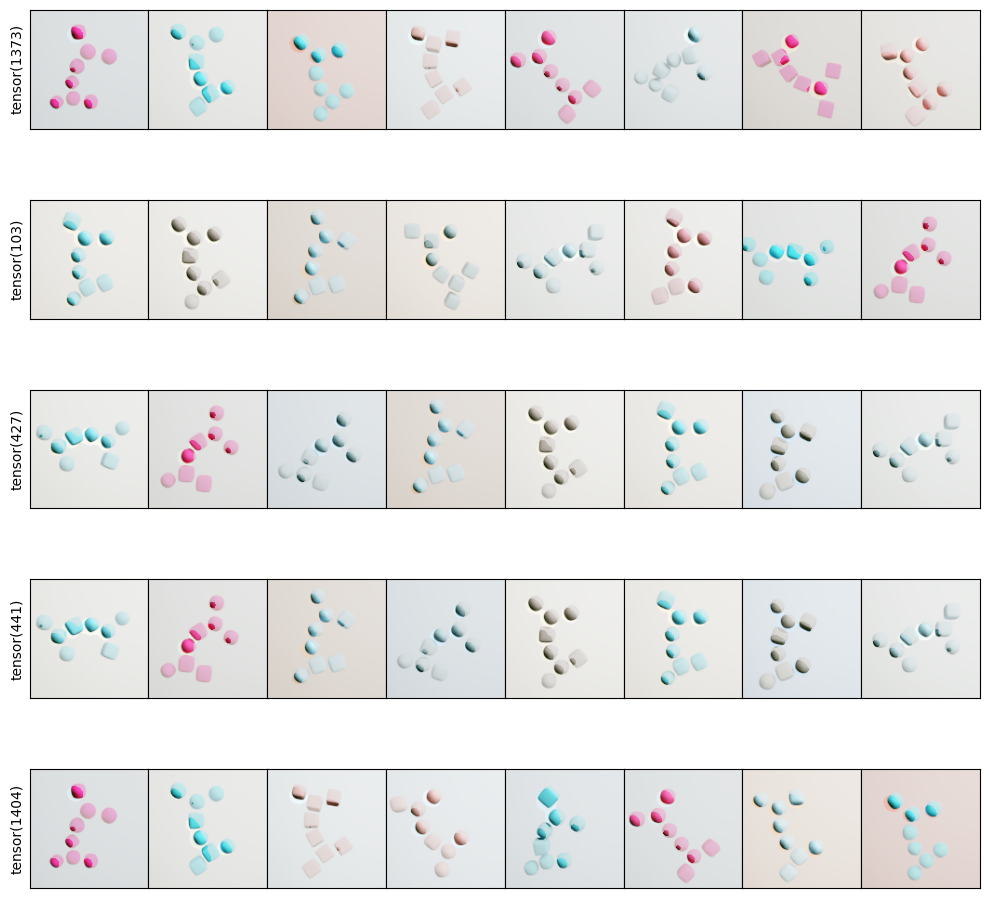

In [ ]:
from crp.image import vis_opaque_img

ref_c = fv.get_max_reference(concept_ids.cpu()[:5], layer_name, "relevance", (0, 8), composite=composite, plot_fn=vis_opaque_img)

plot_grid(ref_c, symmetric=True, figsize=(10, 10))